<a href="https://colab.research.google.com/github/chris-creditdesign/nih-grant-terminations/blob/main/award_remaining_by_state.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Setup
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

df = pd.read_csv("/content/2024-03-31-NIH Grant Terminations_ Auto-Generated - grant_data.csv")

# Drop any rows where the 'cancellation_source' column is not 'HHS reported' or 'Self reported'
df_confirmed = df[df['cancellation_source'].isin(['HHS reported', 'Self reported', 'Self and HHS reported'])]
total_grants_count = len(df_confirmed)
print(f"There are {total_grants_count} rows in the dataframe.")

# Excel file created at: https://report.nih.gov/award/index.cfm?ot=&fy=2024&state=&ic=&fm=&orgid=&distr=&rfa=&om=n&pid=#tab1
df_state_total = pd.read_excel("/content/ABL_20253317549.xlsx")

There are 704 rows in the dataframe.


## Award remaining by State

In [8]:
state_award_remaining = df_confirmed.groupby('org_state')['award_remaining'].sum().sort_values(ascending=False).reset_index()

In [9]:
state_award_remaining.head()

,org_state,award_remaining
0,NY,5.984659e+08
1,NC,5.530157e+08
2,CA,1.954903e+08
3,IL,5.671794e+07
4,TX,5.624307e+07


In [12]:
# https://www.ssa.gov/international/coc-docs/states.html
# Used to match State codes with State names
state_mapping = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
    'District of Columbia': 'DC',
    'Puerto Rico': 'PR',
    'Guam': 'GU',
    'American Samoa': 'AS',
    'U.S. Virgin Islands': 'VI',
    'Northern Mariana Islands': 'MP'
}

In [10]:
# In df_state_total, create a new column with to convert funding from '$1,000,000' strings to numbers
df_state_total['funding_num'] = df_state_total['FUNDING'].astype(str).str.replace(r'[$,]', '', regex=True)
df_state_total['funding_num'] = pd.to_numeric(df_state_total['funding_num'], errors='coerce')

In [13]:
# Add the State Code
df_state_total['state_code'] = df_state_total['LOCATION'].map(state_mapping)

In [14]:
df_state_total.head()

,LOCATION,AWARDS,FUNDING,funding_num,state_code
0,Alabama,722,"$380,343,947",380343947,AL
1,Alaska,24,"$14,833,720",14833720,AK
2,Arizona,593,"$357,034,711",357034711,AZ
3,Arkansas,185,"$108,886,839",108886839,AR
4,California,8875,"$5,152,892,129",5152892129,CA


In [15]:
# Merge the two dataframes
states_merged_df = df_state_total.merge(state_award_remaining, left_on='state_code', right_on='org_state')

In [19]:
# Add a column for the the remaining award amount, as a percentage of the total funding for 2024
states_merged_df['award_remaining_percentage'] = states_merged_df['award_remaining'] / states_merged_df['funding_num'] * 100

In [20]:
states_merged_df.head()

,LOCATION,AWARDS,FUNDING,funding_num,state_code,org_state,award_remaining,award_remaining_percentage
0,Alabama,722,"$380,343,947",380343947,AL,AL,2.917255e+06,0.767004
1,Alaska,24,"$14,833,720",14833720,AK,AK,1.018039e+06,6.863006
2,Arizona,593,"$357,034,711",357034711,AZ,AZ,5.357749e+06,1.500624
3,Arkansas,185,"$108,886,839",108886839,AR,AR,1.220142e+06,1.120560
4,California,8875,"$5,152,892,129",5152892129,CA,CA,1.954903e+08,3.793797


## Chart

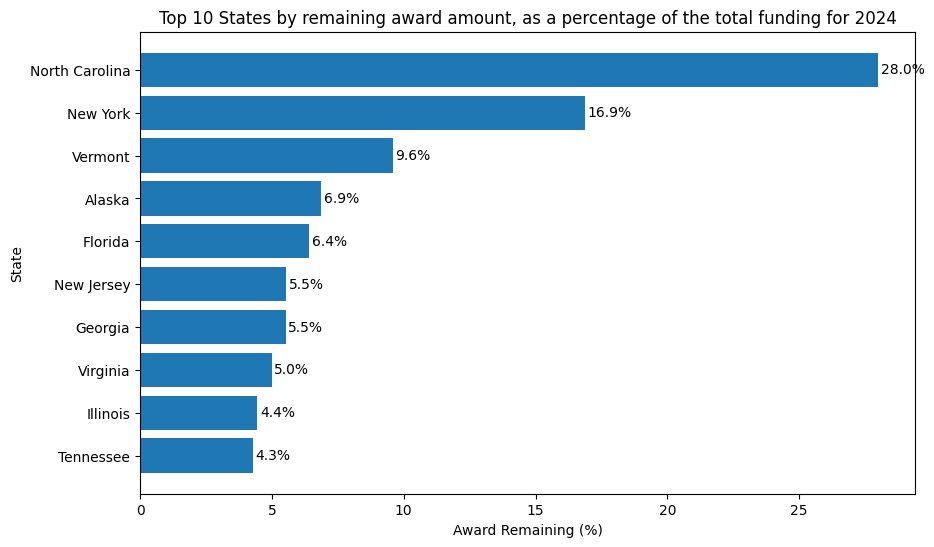

In [24]:
# Sort by award_remaining and get the top 10
top_10_states = states_merged_df.sort_values('award_remaining_percentage', ascending=False).head(10)

plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.barh(top_10_states['LOCATION'], top_10_states['award_remaining_percentage'])
plt.xlabel('Award Remaining (%)')
plt.ylabel('State')
plt.title('Top 10 States by remaining award amount, as a percentage of the total funding for 2024')
plt.gca().invert_yaxis()  # Invert y-axis for better readability

ax = plt.gca()
for p in ax.patches:
    ax.text(p.get_width() + 0.1, p.get_y() + p.get_height() / 2.,
            '{:.1f}%'.format(p.get_width()),
            ha='left', va='center')

plt.show()